In [1]:
import json
import jsonlines
from pyspark import SparkContext

# FILTERING VIDEOS

In [2]:
keywords = {
    'climate change', 'global warming', 'greenhouse gases', 'rising sea levels',
    'extreme weather', 'temperature increase', 'climate action', 
    'carbon emissions', 'renewable energy', 'sustainable living',
    'climate science', 'climate crisis', 'climate adaptation',
    'natural disaster', 'extreme heat', 'melting ice cap', 'sea level rise',
    'biodiversity loss', 'deforestation', 'ocean acidification', 'climate policy', 
    'environmental policy',
    'disaster recovery', 'climate refugees',
    'carbon footprint', 'sustainable development', 'green technology',
    'renewable resource', 'eco-friendly',
    'ecosystem disruption', 'impact on climate',
    'paris agreement', 'climate awareness',
    'environmental justice', 'clean energy', 'zero carbon',
    'green infrastructure', 'ozone layer',
    'pollution', 'water scarcity', 'climate education'
}

keywords2 = {'olympics', 'olympic'}

# Filter functions

In [3]:
#check if text or tags contain climate keywords:
#def idiot_filter(video):
#    return video['upload_date'] > '2015'


def about_climate(tags):
    tags_set = set(tags)
    return any(tag.strip().lower() in keywords2 for tag in tags_set)

def climate_text(text):
    lowercase_text = text.lower()
    return any(keyword in lowercase_text for keyword in keywords2)

def climate_related(video):
    return (climate_text(video['title']) or about_climate(video['tags']) or climate_text(video['description']))
    #return idiot_filter(video) and (climate_text(video['title']) or about_climate(video['tags']) or climate_text(video['description']))

# We read and filter the video dataset using Pyspark

In [4]:
sc = SparkContext()

23/11/15 08:01:59 WARN Utils: Your hostname, sebastien-Inspiron-7391-2n1 resolves to a loopback address: 127.0.1.1; using 192.168.1.73 instead (on interface wlp0s20f3)
23/11/15 08:01:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/15 08:02:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
path_to_disk = '/Volumes/Maxtor'
path_to_disk_ubuntu = '/media/sebastien/Maxtor'
file_path = '/yt_metadata_en.jsonl'

raw_data = sc.textFile(path_to_disk_ubuntu + file_path)
video_dataset = raw_data.map(lambda x: json.loads(x))

In [6]:
climate_videos = video_dataset.filter(climate_related)
climate_videos_collected = climate_videos.collect()

# We save the result in a jsonlines file

In [7]:
climate_videos_path = "data/climate_videos_new.jsonl"
with jsonlines.open(climate_videos_path, "w") as jsonl_file:
   jsonl_file.write_all(climate_videos_collected)

# Count the number of video uploaded each day as well as the views

This may be useful for our future analysis

In [8]:
video_dataset = video_dataset.filter(lambda x: x['view_count'] is not None and x['upload_date'] is not None)
video_per_date = video_dataset.map(lambda x: (x['upload_date'], x['view_count']))
video_per_date = video_per_date.groupBy(lambda x: x[0]).map(lambda x: (x[0], len(x[1]), sum(map(lambda y: y[1], x[1])))).collect()

ERROR:root:KeyboardInterrupt while sending command.            (710 + 8) / 2911]
Traceback (most recent call last):
  File "/home/sebastien/miniconda3/envs/2023/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/sebastien/miniconda3/envs/2023/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/home/sebastien/miniconda3/envs/2023/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt
[Stage 0:=============>                                        (711 + 8) / 2911]
KeyboardInterrupt



# Save the counts in a jsonlines file 

In [ ]:
videos_by_date_path = "data/nb_videos_and_views_by_date.jsonl"
with jsonlines.open(videos_by_date_path, "w") as jsonl_file:
    jsonl_file.write_all(video_per_date)
sc.stop()

In [67]:
import matplotlib.pyplot as plt
import pandas as pd
import json
import seaborn as sns

##### First look at our preprocessed dataset

In [31]:
file_path = "data/climate_videos_new.jsonl"
climate_videos_df = pd.read_json(file_path, lines=True)

<Axes: xlabel='categories'>

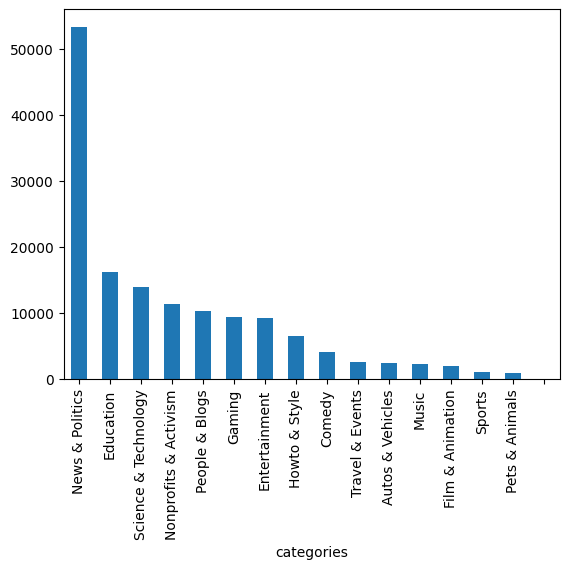

In [33]:
category_counts = climate_videos_df['categories'].value_counts()
category_counts.plot(kind='bar')


Suspicious categories : gaming ?

+ Show that some tite/description do not correspond to climate change related topics

# Filtering refinement

In [82]:
categories = category_counts.reset_index()['categories']

for category in categories:
    print(category)
    print(climate_videos_df[
            climate_videos_df['categories'] == category][
                ['title','description','tags']].head(3))

News & Politics
                                      title  \
204                          GLOBAL WARMING   
205   Al Gore's Paranoia is Getting Worse 😂   
206  Bill Nye: Jail Global Warming Skeptics   

                                           description  \
204  Order your “Liberalism: Find a Cure” or shirts...   
205  CNN had a Town Hall meeting with Al Gore calle...   
206  (((Subscribe))) now for more! http://bit.ly/1Q...   

                                                  tags  
204  2018,Global Warming,Climate Change,Painting St...  
205  Al Gore,Climate Crisis,CNN Town Hall,Al Gore T...  
206  Mark Dice (Person),Bill Nye,Global Warming,Jai...  
Education
                                                 title  \
200  Global warming/ climate change -save planet earth   
342                          Introduction to Economics   
343                       Cap and Trade vs. Carbon Tax   

                                           description  \
200  More than providing entertai

# First analysis and deductions

For each channel we count the number of videos related to climate change

In [35]:
channels_path = 'data/df_channels_en.tsv'

counts = climate_videos_df['channel_id'].value_counts().reset_index()
counts.columns = ['channel','count_climate_videos']

channels_df = pd.read_csv(channels_path, delimiter='\t')

channels_df = channels_df.merge(counts, on ='channel', how ='left').fillna(0)
channels_df['proportion_climate_videos'] = channels_df['count_climate_videos']/channels_df['videos_cc']

display(channels_df)

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,count_climate_videos,proportion_climate_videos
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.0870,0.0,0.000000
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.0870,0.0,0.000000
2,Entertainment,2006-09-20,UCpEhnqL0y41EpW2TvWAHD7Q,SET India,56018869,32661,8.0,2.0870,7.0,0.000214
3,Howto & Style,2016-11-15,UC295-Dw_tDNtZXFeAPAW6Aw,5-Minute Crafts,60600000,3591,9.0,2.0870,13.0,0.003620
4,Sports,2007-05-11,UCJ5v_MCY6GNUBTO8-D3XoAg,WWE,48400000,43421,11.0,2.0870,4.0,0.000092
...,...,...,...,...,...,...,...,...,...,...
136465,Music,2016-10-06,UCuM-9AajUOwKw6ipOzu2DRQ,GONE.Fludd - Topic,10128,105,1008139.0,53.1435,0.0,0.000000
136466,People & Blogs,2013-10-17,UCtW9jp5TH0YrgYpwiRf9t-Q,saidthestory,10100,352,1008644.0,53.1435,0.0,0.000000
136467,Gaming,2015-05-08,UCTsxFTIUs8vFDzGccDm6i7Q,Omni H,10000,475,1009505.0,53.1435,0.0,0.000000
136468,Music,2011-04-13,UC1HOArgRCMGPjlcmkThERwA,TĀLĀ,10000,15,1025119.0,53.1435,0.0,0.000000


In [36]:
display(channels_df.sort_values(by =  'count_climate_videos', ascending= False))

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,count_climate_videos,proportion_climate_videos
87,Nonprofits & Activism,2009-06-23,UCsT0YIqwnpJCM-mx7-gSA4Q,TEDx Talks,20700000,141627,140.0,2.0870,3252.0,0.022962
98565,Comedy,2007-06-21,UCtYjvLEq6FCTWHUX_qtDJpw,paul8kangas,22900,11955,536584.0,9.0000,2784.0,0.232873
37422,Education,2014-07-23,UCp_ShZAUGtFLpYkgcTrayRQ,The Real Truth About...,120000,1597,129397.0,3.9720,1509.0,0.944897
10659,News & Politics,2006-05-21,UC5O114-PQNYkurlTg6hekZw,United Nations,446000,10014,28118.0,3.0245,1215.0,0.121330
13000,Education,2013-09-07,UC6ZQ-SuhvQAeQIR5tHJGGmQ,The Audiopedia,421000,46019,35394.0,3.2170,1143.0,0.024838
...,...,...,...,...,...,...,...,...,...,...
49054,Film and Animation,2012-07-16,UCT1Mq1MaOyXa1qHXPT5dUAw,Shigloo,66700,49,187998.0,5.8195,0.0,0.000000
49053,Entertainment,2017-02-26,UCdjL64S-IS84HjDhSc6XZ2A,Geek Climber,67400,59,187989.0,5.8190,0.0,0.000000
49052,Entertainment,2016-12-11,UC1diQQQOrUsGoSzYKPTXv6g,Dhruvi Shah Dance,82374,83,187986.0,5.8200,0.0,0.000000
49049,Music,2017-02-02,UCySGHFeCusNEu7_ChpAJz4Q,Sad Boy Vibes,80400,652,187958.0,5.8170,0.0,0.000000


In [37]:
display(channels_df.sort_values(by =  'proportion_climate_videos', ascending= False))

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,count_climate_videos,proportion_climate_videos
87404,Howto & Style,2010-04-10,UCa5FbtOmZvP0Z6wR4n7jL8w,Guy Brown,26200,625,442228.0,7.1615,621.0,0.993600
36567,News & Politics,2007-05-25,UC9sXw4ZdPEIp6bYGvLW-_iA,vpro documentary,122743,208,126523.0,3.9190,205.0,0.985577
47134,People & Blogs,2017-09-26,UCsaEBhRsI6tmmz12fkSEYdw,Hot Mess,84226,35,177810.0,5.1875,34.0,0.971429
116703,Nonprofits & Activism,2008-06-04,UCId9tO5LYlJKgNQKEzgjYOg,Médecins Sans Front...,14700,1035,704434.0,10.4760,980.0,0.946860
37422,Education,2014-07-23,UCp_ShZAUGtFLpYkgcTrayRQ,The Real Truth About...,120000,1597,129397.0,3.9720,1509.0,0.944897
...,...,...,...,...,...,...,...,...,...,...
49054,Film and Animation,2012-07-16,UCT1Mq1MaOyXa1qHXPT5dUAw,Shigloo,66700,49,187998.0,5.8195,0.0,0.000000
49053,Entertainment,2017-02-26,UCdjL64S-IS84HjDhSc6XZ2A,Geek Climber,67400,59,187989.0,5.8190,0.0,0.000000
49052,Entertainment,2016-12-11,UC1diQQQOrUsGoSzYKPTXv6g,Dhruvi Shah Dance,82374,83,187986.0,5.8200,0.0,0.000000
49049,Music,2017-02-02,UCySGHFeCusNEu7_ChpAJz4Q,Sad Boy Vibes,80400,652,187958.0,5.8170,0.0,0.000000


(array([1.4393e+04, 1.1600e+02, 3.7000e+01, 2.2000e+01, 9.0000e+00,
        1.1000e+01, 7.0000e+00, 3.0000e+00, 2.0000e+00, 6.0000e+00]),
 array([9.61788157e-06, 9.93686561e-02, 1.98727694e-01, 2.98086733e-01,
        3.97445771e-01, 4.96804809e-01, 5.96163847e-01, 6.95522885e-01,
        7.94881924e-01, 8.94240962e-01, 9.93600000e-01]),
 <BarContainer object of 10 artists>)

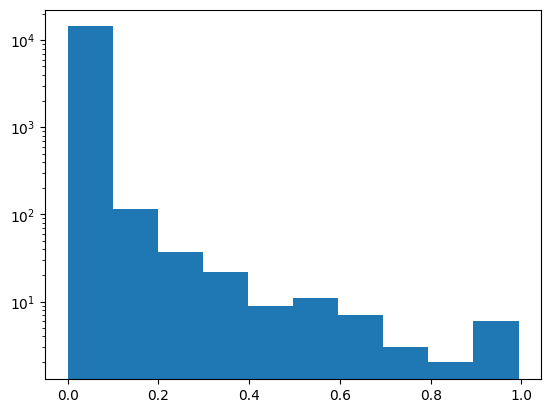

In [38]:
plt.hist(channels_df['proportion_climate_videos'][channels_df['count_climate_videos'] > 0], log = True)

,upload_date,number_of_videos
0,2005-05-29,1
1,2005-06-05,0
2,2005-06-12,0
3,2005-06-19,0
4,2005-06-26,0
...,...,...
752,2019-10-27,50
753,2019-11-03,31
754,2019-11-10,18
755,2019-11-17,26


,upload_date,count
0,2005-07-17,4
1,2005-07-24,2
2,2005-07-31,0
3,2005-08-07,2
4,2005-08-14,0
...,...,...
741,2019-09-29,1779
742,2019-10-06,462
743,2019-10-13,0
744,2019-10-20,0


/Users/paul/anaconda3/envs/ADAenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/paul/anaconda3/envs/ADAenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/paul/anaconda3/envs/ADAenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/paul/anaconda3/envs/ADAenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

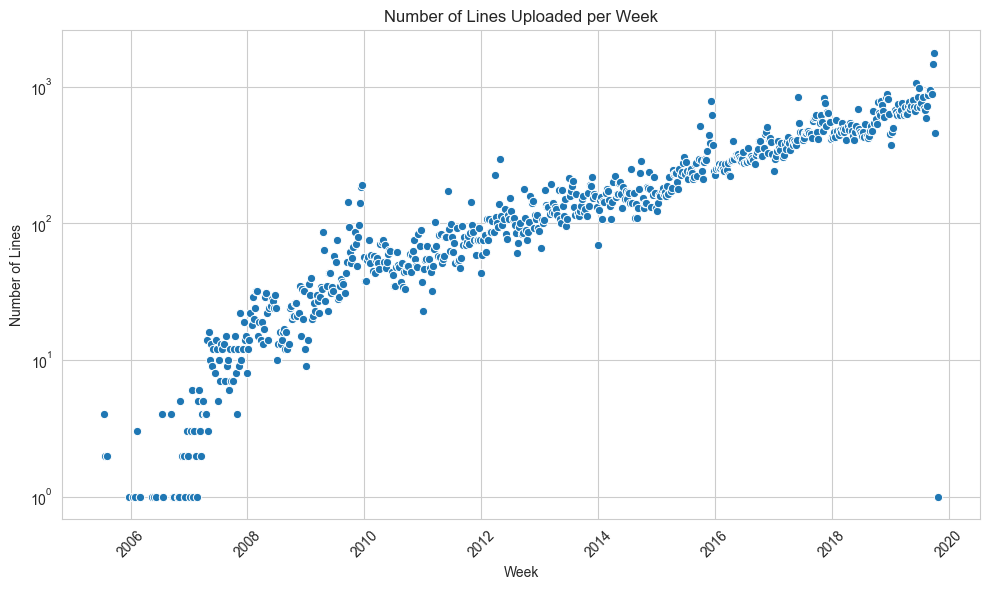

In [92]:
climate_videos_df['upload_date'] = pd.to_datetime(climate_videos_df['upload_date'])

weekly_counts_climate = climate_videos_df.groupby(pd.Grouper(key='upload_date', freq='W')).size().reset_index(name='count')

total_number_videos = pd.read_json("data/nb_videos_by_date.jsonl",lines=True)
total_number_videos.columns = ['upload_date','number_of_videos']
total_number_videos['upload_date'] = pd.to_datetime(total_number_videos['upload_date'])

weekly_counts_total = total_number_videos.groupby(pd.Grouper(key='upload_date', freq='W')).sum().reset_index()

display(weekly_counts_total)
display(weekly_counts_climate)

sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
sns.lineplot(data=weekly_counts_climate, x='upload_date', y='count', marker='o', linestyle='')

plt.title('Number of Lines Uploaded per Week')
plt.xlabel('Week')
plt.ylabel('Number of Lines')

plt.xticks(rotation=45)
plt.yscale('log')

plt.tight_layout()
plt.show()

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import json

In [2]:
file_path = "data/climate_videos_new.jsonl"
climate_videos_df = pd.read_json(file_path, lines=True)

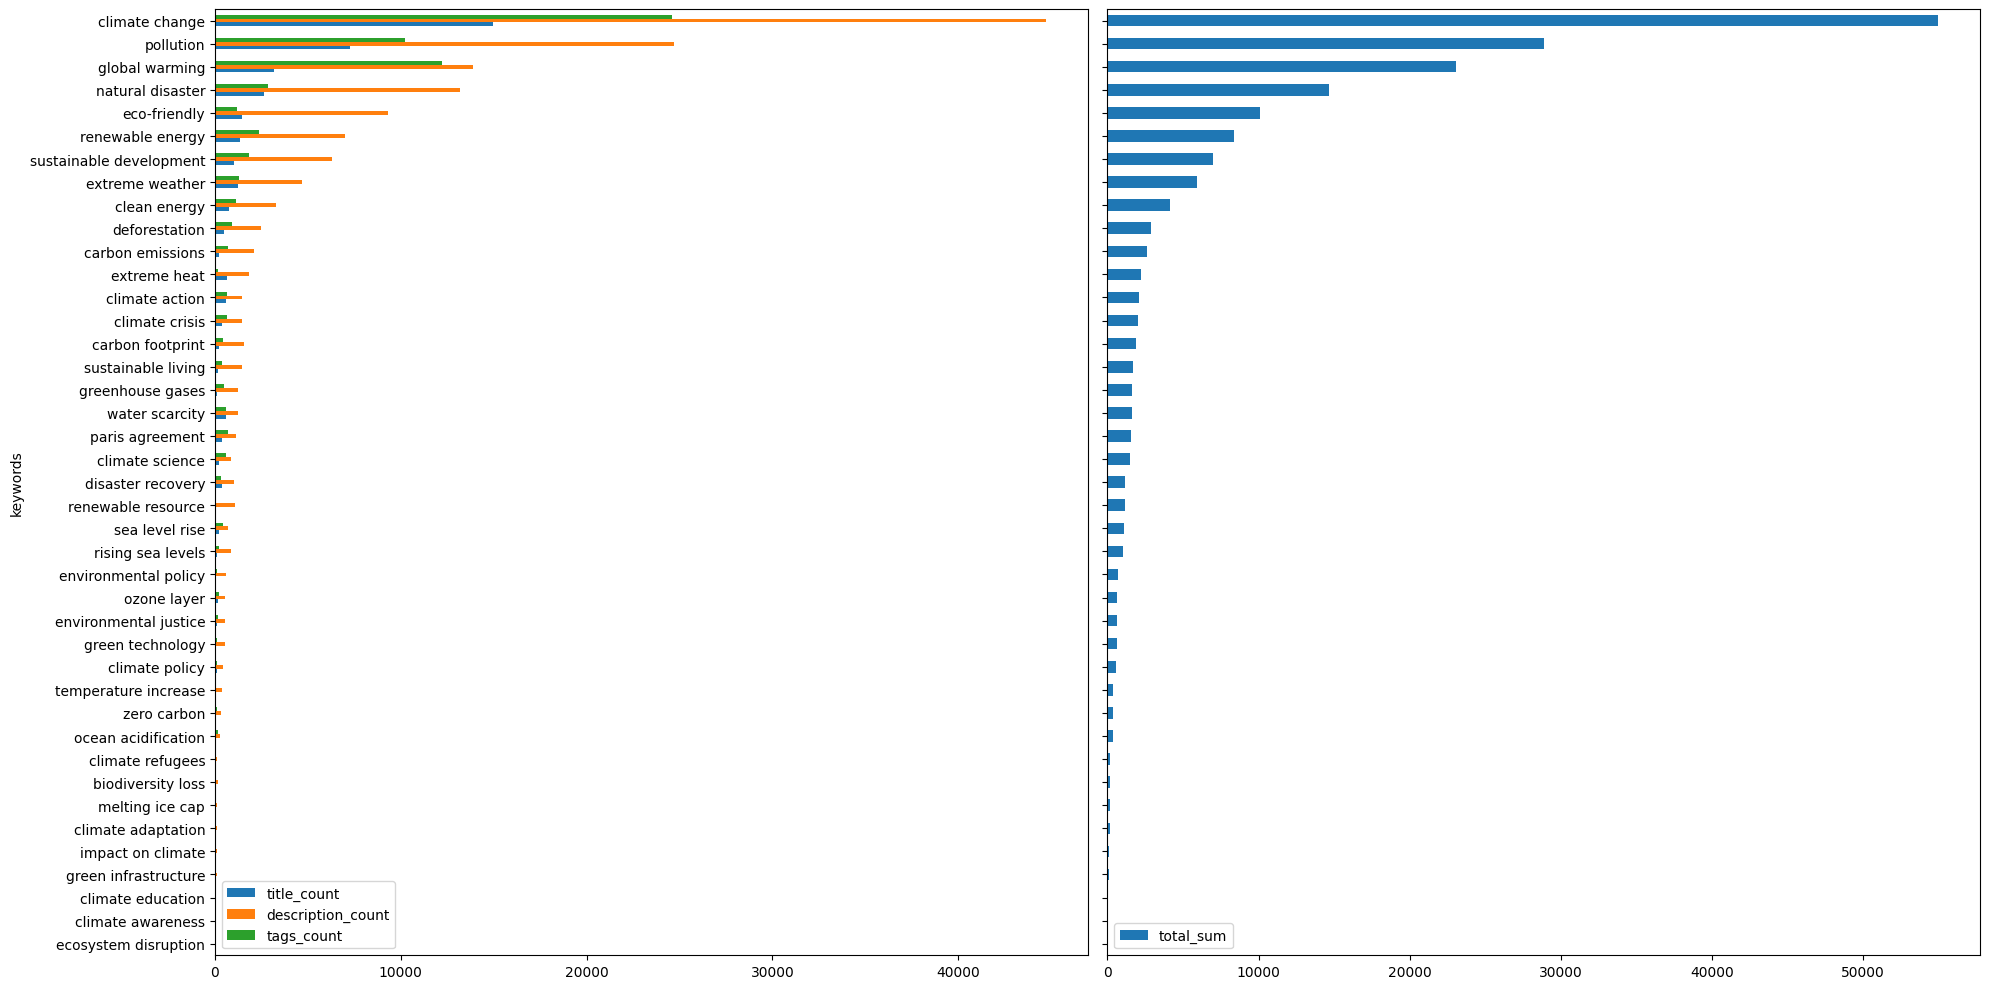

In [90]:
keywords = [
    'climate change', 'global warming', 'greenhouse gases', 'rising sea levels',
    'extreme weather', 'temperature increase', 'climate action', 
    'carbon emissions', 'renewable energy', 'sustainable living',
    'climate science', 'climate crisis', 'climate adaptation',
    'natural disaster', 'extreme heat', 'melting ice cap', 'sea level rise',
    'biodiversity loss', 'deforestation', 'ocean acidification', 'climate policy', 
    'environmental policy',
    'disaster recovery', 'climate refugees',
    'carbon footprint', 'sustainable development', 'green technology',
    'renewable resource', 'eco-friendly',
    'ecosystem disruption', 'impact on climate',
    'paris agreement', 'climate awareness',
    'environmental justice', 'clean energy', 'zero carbon',
    'green infrastructure', 'ozone layer',
    'pollution', 'water scarcity', 'climate education'
]

#keywords = keywords[::5]

keywords_count = pd.DataFrame(columns=['keywords', 'title_count', 'description_count', 'tags_count', 'total_sum'])
keywords_count['keywords'] = keywords
keywords_count.set_index('keywords', inplace=True)

colum_names = ['title', 'description', 'tags']

aug_climate_videos_df = climate_videos_df.copy()

for w in keywords:

    #counts the number of videos that contain the keyword in their metadata
    aug_climate_videos_df['is_' + w] = [1 if w in (climate_videos_df.loc[v, 'title'] + climate_videos_df.loc[v, 'description'] + climate_videos_df.loc[v, 'tags']).lower() else 0 for v in climate_videos_df.index]

    keywords_count.loc[w] = [climate_videos_df[c].str.contains(w, case=False).sum() for c in colum_names] + [aug_climate_videos_df['is_' + w].sum()]

#keywords_count['total_sum'] = keywords_count.sum(axis=1)
keywords_count.sort_values(by=['total_sum'], ascending=True, inplace=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

keywords_count[['title_count', 'description_count', 'tags_count']].plot(kind='barh', ax=ax1)
keywords_count[['total_sum']].plot(kind='barh', ax=ax2)

fig.tight_layout()
plt.show()

#PS: ça prend 1 min a run si on fait pas le count des videos qui contiennent le mot dans leur metadata
#    mais que les counts pour title puis description puis tags

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data

In [2]:
file_path = "data/climate_videos_new.jsonl"
climate_videos_df = pd.read_json(file_path, lines=True)

count_file_path = "data/nb_videos_and_views_by_date.jsonl"
climate_videos_count_df = pd.read_json(count_file_path, lines=True)

# Convert the upload_date column to datetime and set as index

In [3]:
data = climate_videos_df.copy()
data['upload_date'] = pd.to_datetime(climate_videos_df['upload_date'])
data = data.set_index('upload_date')
data.sort_index(inplace=True)

data_count = climate_videos_count_df.copy()
data_count.columns = ['upload_date', 'count', 'views']
data_count.set_index('upload_date', inplace=True)
data_count.index = pd.to_datetime(data_count.index)
data_count.sort_index(inplace=True)

data = data['2009-01-01':'2019-08-01']
data_count = data_count['2009-01-01':'2019-08-01']

In [4]:
data.dropna(inplace=True) # Drop missing values
data.count()

categories       129371
channel_id       129371
crawl_date       129371
description      129371
dislike_count    129371
display_id       129371
duration         129371
like_count       129371
tags             129371
title            129371
view_count       129371
dtype: int64

# Compute the ratio video count and views over time  

In [5]:
# Get video count and views per day
count_per_day = data.groupby(data.index)['view_count'].count()
views_per_day = data.groupby(data.index)['view_count'].sum()

# Compute the ratio with respect to the total number of videos and views
count_per_day = count_per_day / data_count['count'] * 100
views_per_day = views_per_day / data_count['views'] * 100

# Plot number of videos and views over time 

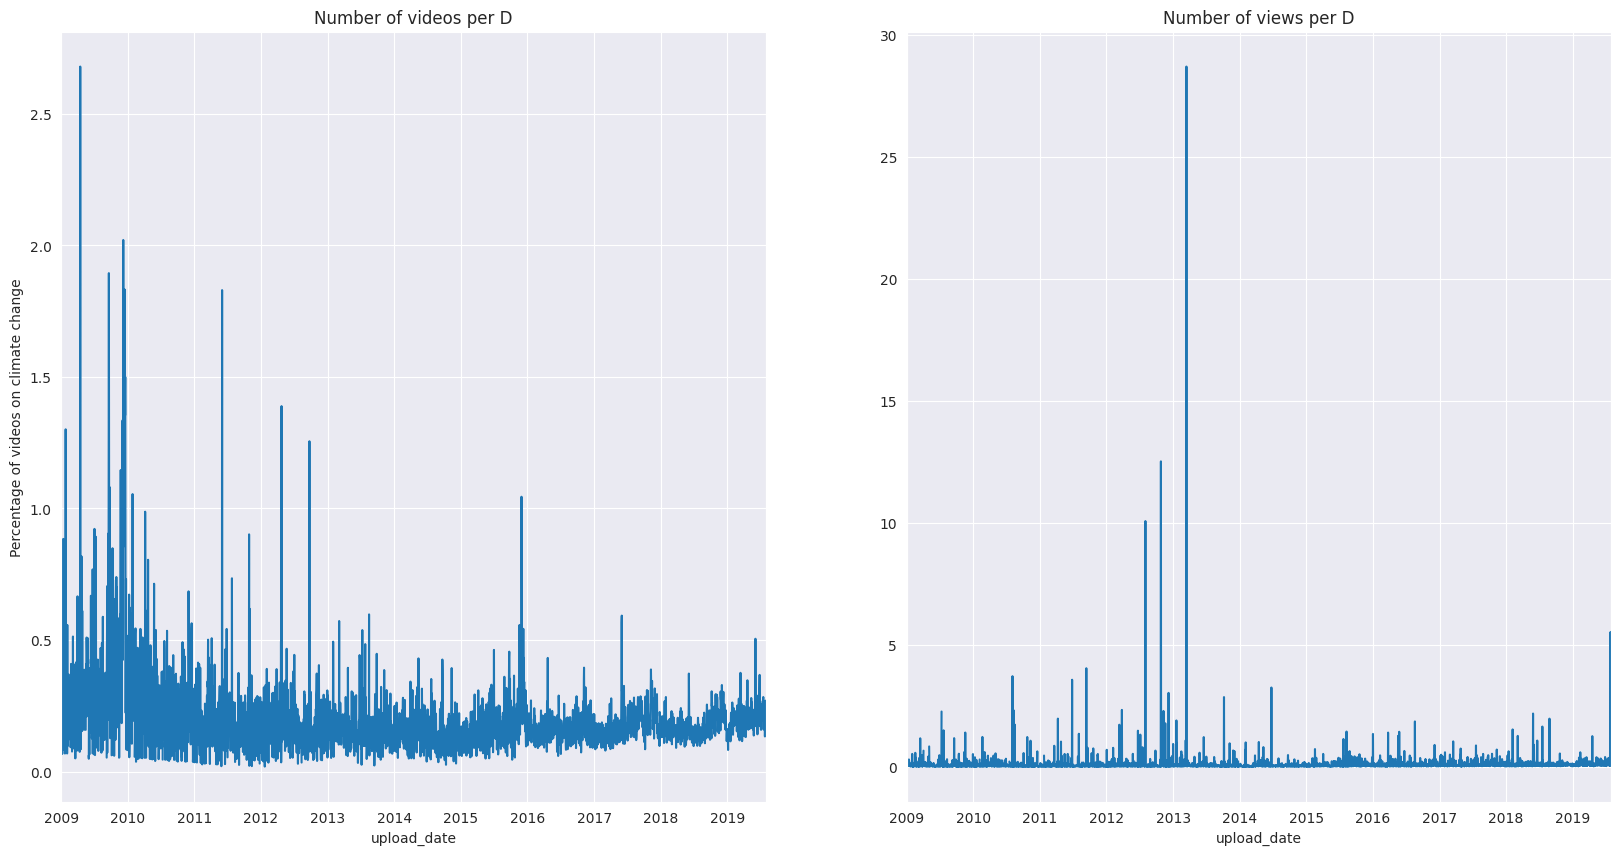

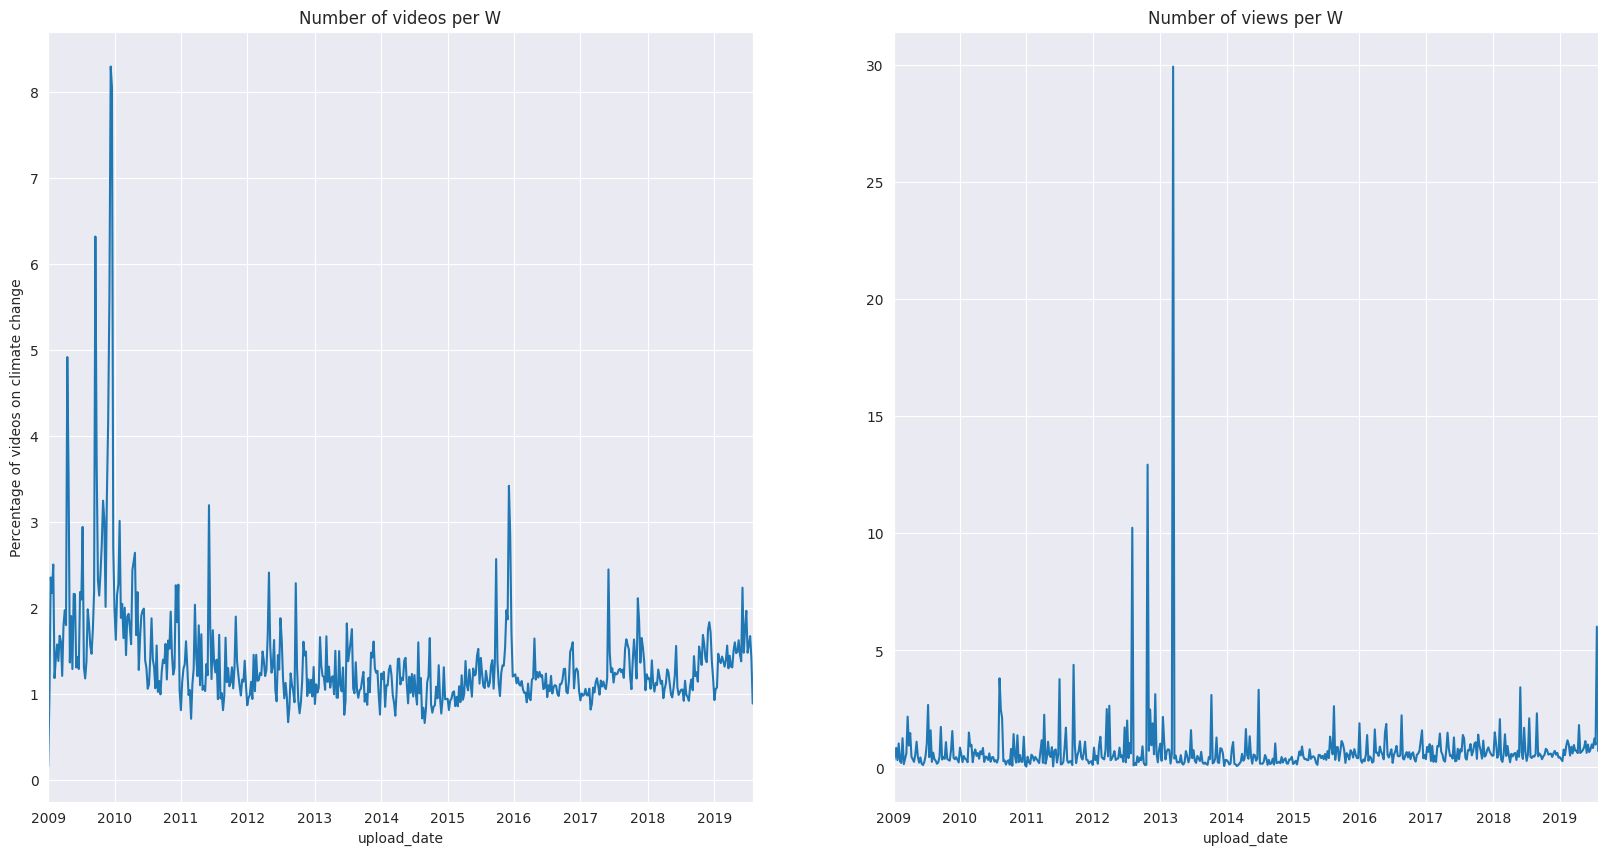

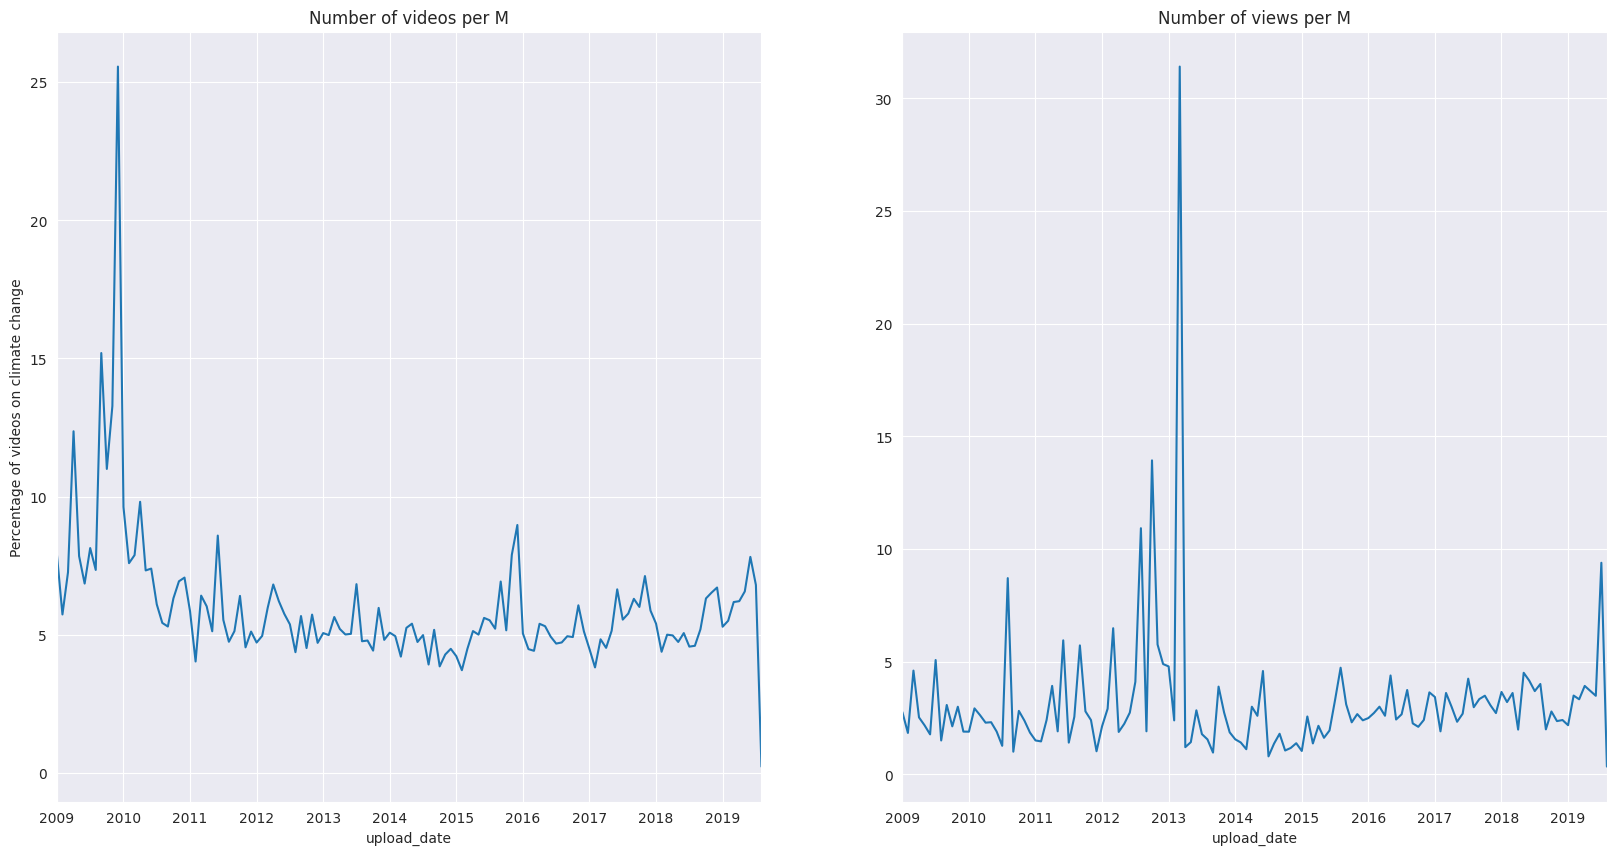

In [6]:
# Create count per month and count per week
count_per_month = count_per_day.resample('M').sum()
count_per_week = count_per_day.resample('W').sum()

# Create views per month and views per week
views_per_month = views_per_day.resample('M').sum()
views_per_week = views_per_day.resample('W').sum()

# Aggregate the views and counts per day, week and month
sample_rate = ['D', 'W', 'M']
counts = [count_per_day, count_per_week, count_per_month]
views = [views_per_day, views_per_week, views_per_month]

# Plot the counts and views for each sample rate
for i in range(3):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    counts[i].plot(ax=ax[0], title=f'Number of videos per {sample_rate[i]}')
    ax[0].set_ylabel('Percentage of videos on climate change')
    views[i].plot(ax=ax[1], title=f'Number of views per {sample_rate[i]}')

In [1]:
# Extract maximum counts and view per week 
sorted_counts = count_per_day.sort_values(ascending=False)
sorted_views = views_per_day.sort_values(ascending=False)

# Print the results
amount = 4
print(f'The {amount} maximum number of videos per week is\n{sorted_counts[:amount]}\n')
print(f'The {amount} maximum number of views per week is\n{sorted_views[:amount]}')

NameError: name 'count_per_day' is not defined

# Load the climate event dataset generated with ChatGPT

In [ ]:
climate_events = pd.read_csv('data/climate_events.csv')
climate_events['date'] = pd.to_datetime(climate_events['date'])
climate_events.set_index('date')

# Find the closet event in terms of time in the climate event dataset

In [ ]:
# TODO: find the closet event to "sorted_views.index[0]"